In [ ]:
import os
import sys
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/src')
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/lensless_imager')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
import numpy as onp
import tensorflow as tf
import tensorflow.keras as tfk

from lensless_helpers import *

from encoding_information import extract_patches
from encoding_information.models import PixelCNN
from encoding_information.models import PoissonNoiseModel
from encoding_information.image_utils import add_noise
from encoding_information import estimate_information

2025-03-29 16:29:38.400103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743290978.418526 1731504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743290978.424395 1731504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cleanplots import *
from scipy.stats import linregress
from skimage.color import rgb2gray
from skimage.transform import downscale_local_mean

In [ ]:
save_dir = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/'

In [4]:
gt_slope, gt_intercept = np.load(save_dir + 'gt_slope_and_intercept.npy')
diffuser_slope, diffuser_intercept = np.load(save_dir + 'diffuser_slope_and_intercept.npy')
rml_slope, rml_intercept = np.load(save_dir + 'rml_slope_and_intercept.npy')

In [5]:
def convert_image_to_photons(image, slope, intercept):
    return (image - intercept) / slope

In [ ]:
measurement_dir = '/home/lakabuli/cosmos_drive/0-25k/'
rml_dir = measurement_dir + 'rml/'
diffuser_dir = measurement_dir + 'diffusercam/'
gt_dir = measurement_dir + 'ground_truth/'

In [ ]:
train_set_index_start = 1000
test_set_index_start = 0
num_test_images = 1000
num_train_images = 10000

train_img_idx = 5
mean_photon_count = 500

(1200, 1920, 3) uint8
(1200, 1200) float32
(1200, 1200) float64 1605.2821940331607 5927.249240394201 4417.101209641229 867.8181869033622
500.0000000000001


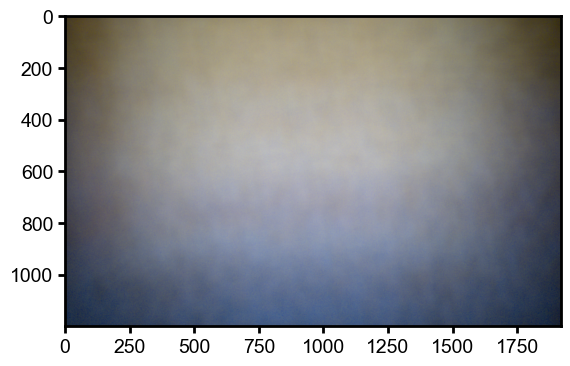

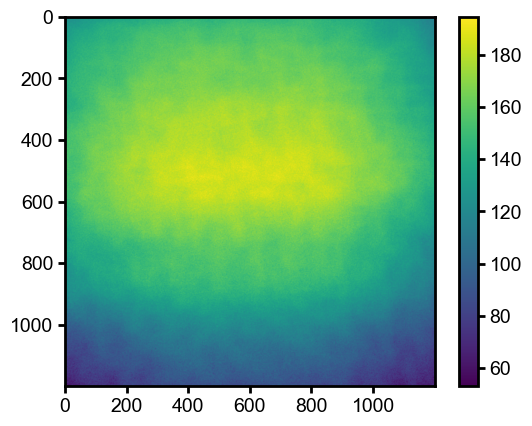

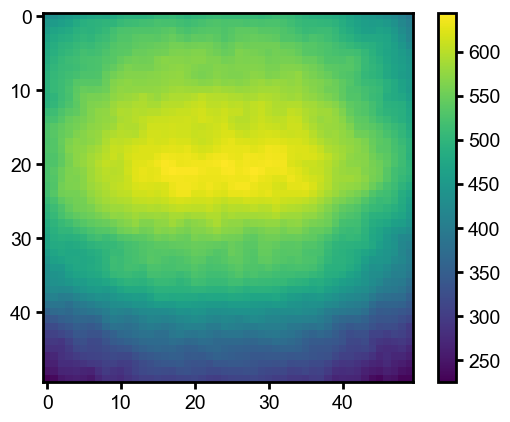

In [ ]:
image_name = 'img_{}_cam_0.tiff'.format(train_set_index_start + train_img_idx)
image = plt.imread(diffuser_dir + image_name)
plt.imshow(image)
print(image.shape, image.dtype)
image = rgb2gray(image).astype(np.float32)
image = image[:, 360:-360]
image = image * 255.0
plt.figure()
plt.imshow(image)
plt.colorbar()
print(image.shape, image.dtype)
image_photons = convert_image_to_photons(image, diffuser_slope, diffuser_intercept)
image_photons = np.clip(image_photons, 0, None)
print(image_photons.shape, image_photons.dtype, np.min(image_photons), np.max(image_photons), np.mean(image_photons), np.std(image_photons))
image_photons = downscale_local_mean(image_photons, (24, 24))
image_photons = image_photons / np.mean(image_photons)
image_photons = image_photons * mean_photon_count
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(np.mean(image_photons))

(1200, 1920, 3) uint8
(1200, 1200) float32
(1200, 1200) float64 1.728545976799652 9642.045883866112 5149.387411058343 1659.162014233287
500.0


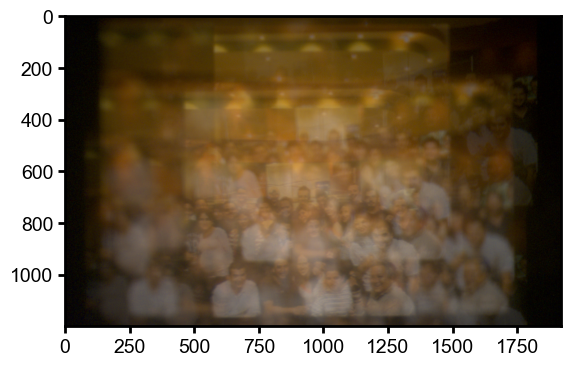

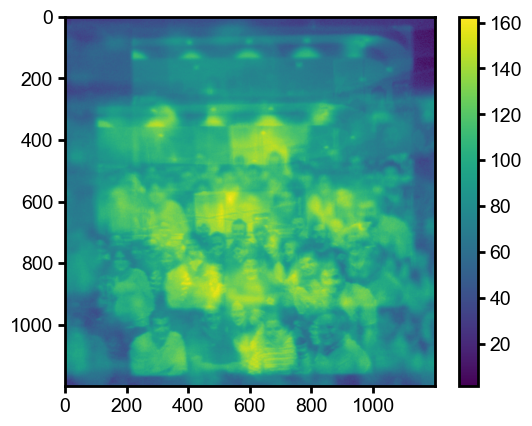

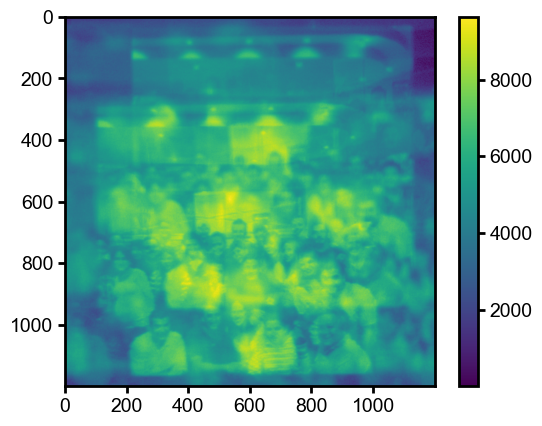

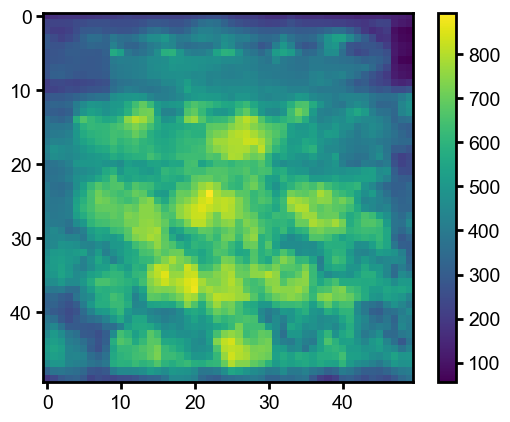

In [ ]:
image_name = 'img_{}_cam_1.tiff'.format(train_set_index_start + train_img_idx)
image = plt.imread(rml_dir + image_name)
plt.imshow(image)
print(image.shape, image.dtype)
image = rgb2gray(image).astype(np.float32)
image = image[:, 360:-360]
image = image * 255.0
plt.figure()
plt.imshow(image)
plt.colorbar()
print(image.shape, image.dtype)
image_photons = convert_image_to_photons(image, rml_slope, rml_intercept)
image_photons = np.clip(image_photons, 0, None)
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(image_photons.shape, image_photons.dtype, np.min(image_photons), np.max(image_photons), np.mean(image_photons), np.std(image_photons))
image_photons = downscale_local_mean(image_photons, (24, 24))
image_photons = image_photons / np.mean(image_photons)
image_photons = image_photons * mean_photon_count
plt.figure()
plt.imshow(image_photons)
plt.colorbar()
print(np.mean(image_photons))

### Generate Downsampled Measurements

In [ ]:
bias = 10
patch_size = 50
train_set_index_start = 1000
test_set_index_start = 0
num_test_images = 1000
num_train_images = 10000

train_img_idx = 5
mean_photon_count = 500

seed_value = 42
learning_rate = 1e-3
num_iters_per_epoch = 500
patience_val = 20

In [ ]:
imager_type = 'gt'
patch_size = 50
full_dataset = []
for image_idx in range(num_train_images + num_test_images):
    if image_idx % 1000 == 0:
        print('Loading image {} of {}'.format(image_idx, num_train_images + num_test_images))
    image_name = 'img_{}_cam_2.tiff'.format(image_idx)
    image = plt.imread(gt_dir + image_name)
    image = rgb2gray(image).astype(np.float32)
    image = image * 255.0
    image = image[210:1010, 600:1400]
    image_photons = convert_image_to_photons(image, gt_slope, gt_intercept)
    image_photons = np.clip(image_photons, 0, None)
    image_photons = downscale_local_mean(image_photons, (16, 16))
    assert image_photons.shape == (patch_size, patch_size), f'Image shape is {image_photons.shape}, expected {patch_size, patch_size}'
    full_dataset.append(image_photons)
full_dataset = np.array(full_dataset).astype(np.float32)
np.save(save_dir + '{}_dataset_{}_patch_{}_images.npy'.format(imager_type, patch_size, num_train_images + num_test_images), full_dataset)
print(full_dataset.shape, full_dataset.dtype, np.min(full_dataset), np.max(full_dataset), np.mean(full_dataset), np.std(full_dataset))

Loading image 0 of 11000


Loading image 1000 of 11000
Loading image 2000 of 11000
Loading image 3000 of 11000
Loading image 4000 of 11000
Loading image 5000 of 11000
Loading image 6000 of 11000
Loading image 7000 of 11000
Loading image 8000 of 11000
Loading image 9000 of 11000
Loading image 10000 of 11000
(11000, 50, 50) float32 0.0 4388.5566 1159.491 814.9961


In [ ]:
imager_type = 'gt'
patch_size = 100
full_dataset = []
for image_idx in range(num_train_images + num_test_images):
    if image_idx % 1000 == 0:
        print('Loading image {} of {}'.format(image_idx, num_train_images + num_test_images))
    image_name = 'img_{}_cam_2.tiff'.format(image_idx)
    image = plt.imread(gt_dir + image_name)
    image = rgb2gray(image).astype(np.float32)
    image = image * 255.0
    image = image[210:1010, 600:1400]
    image_photons = convert_image_to_photons(image, gt_slope, gt_intercept)
    image_photons = np.clip(image_photons, 0, None)
    image_photons = downscale_local_mean(image_photons, (8, 8))
    assert image_photons.shape == (patch_size, patch_size), f'Image shape is {image_photons.shape}, expected {patch_size, patch_size}'
    full_dataset.append(image_photons)
full_dataset = np.array(full_dataset).astype(np.float32)
np.save(save_dir + '{}_dataset_{}_patch_{}_images.npy'.format(imager_type, patch_size, num_train_images + num_test_images), full_dataset)
print(full_dataset.shape, full_dataset.dtype, np.min(full_dataset), np.max(full_dataset), np.mean(full_dataset), np.std(full_dataset))

Loading image 0 of 11000
Loading image 1000 of 11000
Loading image 2000 of 11000
Loading image 3000 of 11000
Loading image 4000 of 11000
Loading image 5000 of 11000
Loading image 6000 of 11000
Loading image 7000 of 11000
Loading image 8000 of 11000
Loading image 9000 of 11000
Loading image 10000 of 11000
(11000, 100, 100) float32 0.0 4418.9287 1159.4907 833.65436


In [ ]:
imager_type = 'rml'
patch_size = 100
full_dataset = []
for image_idx in range(num_train_images + num_test_images):
    if image_idx % 1000 == 0:
        print('Loading image {} of {}'.format(image_idx, num_train_images + num_test_images))
    image_name = 'img_{}_cam_1.tiff'.format(image_idx)
    image = plt.imread(rml_dir + image_name)
    image = rgb2gray(image).astype(np.float32)
    image = image * 255.0
    image = image[:, 360:-360]
    image_photons = convert_image_to_photons(image, rml_slope, rml_intercept)
    image_photons = np.clip(image_photons, 0, None)
    image_photons = downscale_local_mean(image_photons, (12, 12))
    assert image_photons.shape == (patch_size, patch_size), f'Image shape is {image_photons.shape}, expected {patch_size, patch_size}'
    full_dataset.append(image_photons)
full_dataset = np.array(full_dataset).astype(np.float32)
np.save(save_dir + '{}_dataset_{}_patch_{}_images.npy'.format(imager_type, patch_size, num_train_images + num_test_images), full_dataset)
print(full_dataset.shape, full_dataset.dtype, np.min(full_dataset), np.max(full_dataset), np.mean(full_dataset), np.std(full_dataset))

Loading image 0 of 11000


Loading image 1000 of 11000
Loading image 2000 of 11000
Loading image 3000 of 11000
Loading image 4000 of 11000
Loading image 5000 of 11000
Loading image 6000 of 11000
Loading image 7000 of 11000
Loading image 8000 of 11000
Loading image 9000 of 11000
Loading image 10000 of 11000
(11000, 100, 100) float32 0.0 14874.444 4614.3706 2570.3918


In [ ]:
imager_type = 'diffuser'
patch_size = 100
full_dataset = []
for image_idx in range(num_train_images + num_test_images):
    if image_idx % 1000 == 0:
        print('Loading image {} of {}'.format(image_idx, num_train_images + num_test_images))
    image_name = 'img_{}_cam_0.tiff'.format(image_idx)
    image = plt.imread(diffuser_dir + image_name)
    image = rgb2gray(image).astype(np.float32)
    image = image * 255.0
    image = image[:, 360:-360]
    image_photons = convert_image_to_photons(image, diffuser_slope, diffuser_intercept)
    image_photons = np.clip(image_photons, 0, None)
    image_photons = downscale_local_mean(image_photons, (12, 12))
    assert image_photons.shape == (patch_size, patch_size), f'Image shape is {image_photons.shape}, expected {patch_size, patch_size}'
    full_dataset.append(image_photons)
full_dataset = np.array(full_dataset).astype(np.float32)
np.save(save_dir + '{}_dataset_{}_patch_{}_images.npy'.format(imager_type, patch_size, num_train_images + num_test_images), full_dataset)
print(full_dataset.shape, full_dataset.dtype, np.min(full_dataset), np.max(full_dataset), np.mean(full_dataset), np.std(full_dataset))

Loading image 0 of 11000


Loading image 1000 of 11000
Loading image 2000 of 11000
Loading image 3000 of 11000
Loading image 4000 of 11000
Loading image 5000 of 11000
Loading image 6000 of 11000
Loading image 7000 of 11000
Loading image 8000 of 11000
Loading image 9000 of 11000
Loading image 10000 of 11000
(11000, 100, 100) float32 1.6321669 7769.0903 4228.686 1480.6819
